In [ ]:
!pip install torchmetrics --quiet
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 5.2 MB/s eta 0:00:00


In [ ]:
import os
import csv
import torch
import pickle
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torchmetrics import AUROC, F1Score

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set the path to your files in Google Drive
drive_path = '/content/drive/My Drive/Kaggle/'

# Load the data
train_x = pd.read_csv(drive_path + 'train_x.csv')
train_y = pd.read_csv(drive_path + 'train_y.csv')
val_x = pd.read_csv(drive_path + 'val_x.csv')
val_y = pd.read_csv(drive_path + 'val_y.csv')
test_x = pd.read_csv(drive_path + 'test_x.csv')


Mounted at /content/drive


In [ ]:
#Create joined datasets
train_data = pd.concat([train_x, train_y], axis=1)
val_data = pd.concat([val_x, val_y], axis=1)

In [ ]:
display(train_data.head())

,index,string,male,female,LGBTQ,christian,muslim,other_religions,black,white,identity_any,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,y,from_source_domain
0,0,even up here.......BLACKS!,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1
1,1,Blame men. There's always an excuse to blame ...,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1
2,2,You have no business making any comments on th...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
3,3,"""Let's get the black folks and the white folks...",0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,1
4,4,I guess the issue is people not willing to put...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1


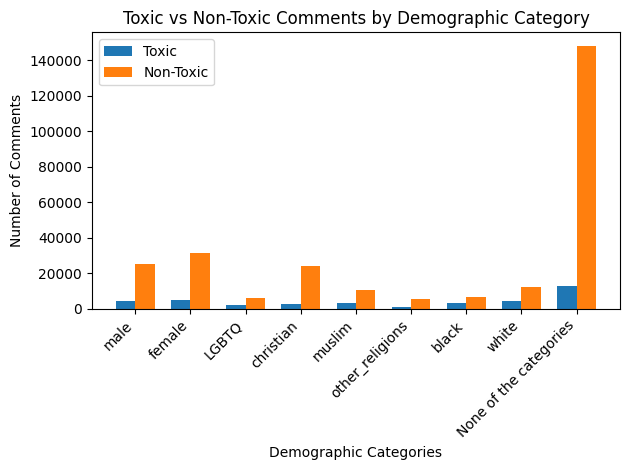

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample data
df = pd.DataFrame(train_data)

# Categories of interest
categories = ["male", "female", "LGBTQ", "christian", "muslim", "other_religions", "black", "white"]

# Count toxic and non-toxic comments for each category
toxic_counts = []
nontoxic_counts = []
for category in categories:
    toxic_count = df[(df[category] == 1) & (df['y'] == 1)].shape[0]
    nontoxic_count = df[(df[category] == 1) & (df['y'] == 0)].shape[0]
    toxic_counts.append(toxic_count)
    nontoxic_counts.append(nontoxic_count)

# Add counts for comments that don't fit in any category
df['sum_categories'] = df[categories].sum(axis=1)
toxic_count_none = df[(df['sum_categories'] == 0) & (df['y'] == 1)].shape[0]
nontoxic_count_none = df[(df['sum_categories'] == 0) & (df['y'] == 0)].shape[0]
toxic_counts.append(toxic_count_none)
nontoxic_counts.append(nontoxic_count_none)
categories.append('None of the categories')  # Add a label for the 'None of the categories' data

# Plotting
bar_width = 0.35
index = np.arange(len(categories))  # Use np.arange instead of pd.np.arange
fig, ax = plt.subplots()
bar1 = ax.bar(index, toxic_counts, bar_width, label='Toxic')
bar2 = ax.bar(index + bar_width, nontoxic_counts, bar_width, label='Non-Toxic')

# Labeling
ax.set_xlabel('Demographic Categories')
ax.set_ylabel('Number of Comments')
ax.set_title('Toxic vs Non-Toxic Comments by Demographic Category')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Data preprocessing

## Tokenizing

In [ ]:
from transformers import DistilBertTokenizer

# Initialize the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
import torch
from torch.utils.data import Dataset

In [ ]:
class TokenizedCommentDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len: int, eval_mode: bool = False,):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.comments = dataframe.string
        self.max_len = max_len
        self.eval_mode = eval_mode
        self.demographic_columns = ["male", "female", "LGBTQ", "christian", "muslim", "other_religions", "black", "white"]
        if not self.eval_mode:
            self.y = self.data.y
            self.demographic_columns = ["male", "female", "LGBTQ", "christian", "muslim", "other_religions", "black", "white"]

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, index):
        comment = str(self.comments.iloc[index])
        inputs = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_len
        )

        # Preparing the dictionary to be returned
        output = {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'comment': comment,
            'tokens': self.tokenizer.convert_ids_to_tokens(inputs['input_ids']),
            'index': index,
            'y': torch.tensor(self.data.y.iloc[index], dtype=torch.int),

        }
        for column in self.demographic_columns:
          output[column] = torch.tensor(self.data[column].iloc[index], dtype=torch.int)

        if not self.eval_mode:
            output['y'] = torch.tensor(self.y.iloc[index], dtype=torch.int)
            for column in self.demographic_columns:
                output[column] = torch.tensor(self.data[column].iloc[index], dtype=torch.int)

        return output


In [ ]:
max_len = 512
train_dataset = TokenizedCommentDataset(train_data[:2000], tokenizer, max_len, eval_mode=False)
val_dataset = TokenizedCommentDataset(val_data[:2000], tokenizer, max_len, eval_mode=True)


In [ ]:
train_dataset[0]

{'ids': tensor([  101,  2130,  2039,  2182,  1012,  1012,  1012,  1012,  1012,  1012,
          1012, 10823,   999,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,  

In [ ]:
# Creating Dataloader
from torch.utils.data import DataLoader

TRAIN_BATCH_SIZE = 32
NUM_WORKERS = 0

# Create DataLoader for training data
training_loader = DataLoader(
    dataset=train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)



# Create DataLoader for validation data
validation_loader = DataLoader(
    dataset=val_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=False,  # Note: Typically, you don't need to shuffle validation data. If that's the case, set shuffle=False.
    num_workers=NUM_WORKERS
)

def custom_collate_fn(batch):
    # Check and handle missing 'y' in the batch
    # Return the batch or a modified version of it
    return batch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for i, data in enumerate(training_loader):
    # If 'y' is not in data, print the batch number and the keys
    if 'y' not in data:
        print(f"Batch {i} keys: {data.keys()}")
        print(data)  # You can temporarily print the whole batch to investigate
    else:
        # Your existing code
        input_ids = data['ids'].to(device, dtype=torch.long)
        attention_mask = data['mask'].to(device, dtype=torch.long)
        true_values = data['y'].to(device, dtype=torch.float)
        # Rest of your training or evaluation code...


## Neural Network

In [ ]:
from transformers import DistilBertModel
import torch

class DistilBERTClass(torch.nn.Module):

    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.5)
        self.classifier = torch.nn.Linear(768, 1)
        self.tanh = torch.nn.Tanh()

    def forward(self, input_ids, attention_mask):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = distilbert_output[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = self.tanh(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBERTClass()
model.to(device)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBERTClass(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): L

## Loss function and optimizer

In [ ]:
import torch

def loss_fn(outputs, targets):
    loss_function = torch.nn.BCEWithLogitsLoss()
    return loss_function(outputs.view(-1), targets.view(-1))

LEARNING_RATE = 1e-05

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np

def worst_group_accuracy(prediction, y):

    y.loc[prediction.index, 'pred'] = prediction['prediction']

    categories = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
    accuracies_dict = {}

    for category in categories:
        for label in [0, 1]:
            group = y.loc[y[category] == label]
            group_accuracy = (group['y'] == (group['pred'] > 0.5)).mean()
            accuracies_dict[(category, label)] = group_accuracy

    worst_group = min(accuracies_dict, key=accuracies_dict.get)
    wga = accuracies_dict[worst_group]

    return wga, worst_group, accuracies_dict

def analyze_model_performance(data_loader, model):
    model.eval()
    total_validation_loss, total_validation_accuracy, all_predictions = 0, 0, []
    all_true_labels = {key: [] for key in ['y', 'male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']}

    with torch.no_grad():
        for data in tqdm(data_loader, desc='Evaluating', leave=False):
            input_ids = data['ids'].to(device, dtype=torch.long)
            attention_mask = data['mask'].to(device, dtype=torch.long)
            true_values = data['y'].to(device, dtype=torch.float)

            model_predictions = model(input_ids, attention_mask).squeeze()
            loss = loss_fn(model_predictions, true_values)

            total_validation_loss += loss.item()
            total_validation_accuracy += accuracy_score(true_values.cpu().numpy(), model_predictions.cpu().numpy().round())
            all_predictions.extend(model_predictions.cpu().numpy())
            for key in all_true_labels.keys():
                all_true_labels[key].extend(data[key].cpu().numpy())

    average_validation_loss = total_validation_loss / len(data_loader)
    average_validation_accuracy = total_validation_accuracy / len(data_loader)

    least_accuracy, least_accurate_group, group_accuracy_details = worst_group_accuracy(pd.DataFrame({'prediction': all_predictions}), pd.DataFrame(all_true_labels))

    return average_validation_loss, average_validation_accuracy, least_accuracy, least_accurate_group, group_accuracy_details

def execute_training(num_epochs, training_data_loader, validation_data_loader):
    training_losses, validation_losses = [], []
    training_least_accuracies, validation_least_accuracies = [], []
    training_least_accurate_groups, validation_least_accurate_groups = [], []
    accuracies_per_group_during_training, accuracies_per_group_during_validation = [], []

    for epoch in range(num_epochs):
        model.train()
        cumulative_loss = 0
        epoch_predictions = []
        epoch_true_labels = {key: [] for key in ['y', 'male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']}

        for batch in tqdm(training_data_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
            input_ids = batch['ids'].to(device, dtype=torch.long)
            attention_mask = batch['mask'].to(device, dtype=torch.long)
            true_values = batch['y'].to(device, dtype=torch.float)

            optimizer.zero_grad()
            predictions = model(input_ids, attention_mask).squeeze()
            loss = loss_fn(predictions, true_values)
            loss.backward()
            optimizer.step()

            cumulative_loss += loss.item()
            epoch_predictions.extend(predictions.cpu().detach().numpy())
            for key in epoch_true_labels.keys():
                epoch_true_labels[key].extend(batch[key].cpu().numpy())

        average_loss_during_training = cumulative_loss / len(training_data_loader)
        training_losses.append(average_loss_during_training)

        training_least_accuracy, training_least_accurate_group, training_group_accuracy_details = worst_group_accuracy(pd.DataFrame({'prediction': epoch_predictions}), pd.DataFrame(epoch_true_labels))
        training_least_accuracies.append(training_least_accuracy)
        training_least_accurate_groups.append(training_least_accurate_group)
        accuracies_per_group_during_training.append(training_group_accuracy_details)

        average_validation_loss, average_validation_accuracy, validation_least_accuracy, validation_least_accurate_group, validation_group_accuracy_details = analyze_model_performance(validation_data_loader, model)
        validation_losses.append(average_validation_loss)
        validation_least_accuracies.append(validation_least_accuracy)
        validation_least_accurate_groups.append(validation_least_accurate_group)
        accuracies_per_group_during_validation.append(validation_group_accuracy_details)

        print(f'Training Loss: {average_loss_during_training:.4f}, Training Least Group Accuracy: {training_least_accuracy:.4f}, Validation Loss: {average_validation_loss:.4f}, Validation Least Group Accuracy: {validation_least_accuracy:.4f}')

        sorted_training_group_accuracies = dict(sorted(training_group_accuracy_details.items(), key=lambda item: item[1]))
        print(f"Sorted Training Group Accuracies: {sorted_training_group_accuracies}")

        sorted_validation_group_accuracies = dict(sorted(validation_group_accuracy_details.items(), key=lambda item: item[1]))
        print(f"Sorted Validation Group Accuracies: {sorted_validation_group_accuracies}")

    epoch_range = range(1, len(training_losses) + 1)
    fig, (loss_axis, accuracy_axis) = plt.subplots(1, 2, figsize=(20, 6))

    loss_axis.plot(epoch_range, training_losses, label='Training Loss', color='blue')
    loss_axis.plot(epoch_range, validation_losses, label='Validation Loss', color='red')
    loss_axis.set_title('Training and Validation Loss Over Epochs')
    loss_axis.set_xlabel('Epochs')
    loss_axis.set_ylabel('Loss')
    loss_axis.legend()
    loss_axis.grid(True)

    for group in accuracies_per_group_during_training[0].keys():
        training_group_accuracy = [accuracy[group] for accuracy in accuracies_per_group_during_training]
        validation_group_accuracy = [accuracy[group] for accuracy in accuracies_per_group_during_validation]

        accuracy_axis.plot(epoch_range, training_group_accuracy, color='green', alpha=0.5)
        accuracy_axis.plot(epoch_range, validation_group_accuracy, color='orange', alpha=0.5)

    accuracy_axis.set_title('Training and Validation Accuracies for Each Group Over Epochs')
    accuracy_axis.set_xlabel('Epochs')
    accuracy_axis.set_ylabel('Accuracy')
    accuracy_axis.legend(['Training Accuracies', 'Validation Accuracies'], loc='upper left')
    accuracy_axis.grid(True)

    plt.tight_layout()
    plt.show()

    return training_losses, training_least_accuracies, training_least_accurate_groups, accuracies_per_group_during_training, validation_losses, validation_least_accuracies, validation_least_accurate_groups, accuracies_per_group_during_validation


In [ ]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print(f"CUDA is available! 🎉")
    # Get the name of the CUDA device
    cuda_device_name = torch.cuda.get_device_name(torch.cuda.current_device())
    print(f"Using device: {cuda_device_name}")
else:
    print("CUDA is not available. 😞 Running on CPU.")


CUDA is available! 🎉
Using device: Tesla T4


In [ ]:
for data in tqdm(training_loader, desc='Evaluating', leave=False):
  print(data.keys())
for data in tqdm(validation_loader, desc='Evaluating', leave=False):
    print(data.keys())



dict_keys(['ids', 'mask', 'comment', 'tokens', 'index', 'y', 'male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white'])
dict_keys(['ids', 'mask', 'comment', 'tokens', 'index', 'y', 'male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white'])
dict_keys(['ids', 'mask', 'comment', 'tokens', 'index', 'y', 'male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white'])
dict_keys(['ids', 'mask', 'comment', 'tokens', 'index', 'y', 'male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white'])


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

dict_keys(['ids', 'mask', 'comment', 'tokens', 'index', 'y', 'male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white'])


dict_keys(['ids', 'mask', 'comment', 'tokens', 'index', 'y', 'male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white'])
dict_keys(['ids', 'mask', 'comment', 'tokens', 'index', 'y', 'male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white'])
dict_keys(['ids', 'mask', 'comment', 'tokens', 'index', 'y', 'male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white'])


Epoch 1/4 - Training: 100%|██████████| 63/63 [01:30<00:00,  1.44s/it]


Training Loss: 0.4437, Training Least Group Accuracy: 0.6591, Validation Loss: 0.4343, Validation Least Group Accuracy: 0.6800
Sorted Training Group Accuracies: {('other_religions', 1): 0.6590909090909091, ('muslim', 1): 0.7094017094017094, ('black', 1): 0.7096774193548387, ('white', 1): 0.7268722466960352, ('female', 1): 0.7450980392156863, ('christian', 1): 0.7473684210526316, ('male', 1): 0.766798418972332, ('LGBTQ', 0): 0.7681462140992167, ('male', 0): 0.7698912421293647, ('christian', 0): 0.7706036745406825, ('other_religions', 0): 0.7719836400817995, ('muslim', 0): 0.7732342007434945, ('female', 0): 0.7739079102715466, ('black', 0): 0.7745257452574525, ('white', 0): 0.7749576988155669, ('LGBTQ', 1): 0.8}
Sorted Validation Group Accuracies: {('other_religions', 1): 0.68, ('LGBTQ', 1): 0.7254901960784313, ('christian', 1): 0.7676767676767676, ('muslim', 1): 0.7692307692307693, ('female', 1): 0.7752808988764045, ('black', 1): 0.7819548872180451, ('male', 0): 0.7860411899313501, ('wh

Epoch 2/4 - Training: 100%|██████████| 63/63 [01:30<00:00,  1.44s/it]


Training Loss: 0.3357, Training Least Group Accuracy: 0.8106, Validation Loss: 0.4485, Validation Least Group Accuracy: 0.7000
Sorted Training Group Accuracies: {('white', 1): 0.8105726872246696, ('other_religions', 1): 0.8181818181818182, ('muslim', 1): 0.8205128205128205, ('black', 1): 0.832258064516129, ('female', 1): 0.8333333333333334, ('christian', 1): 0.8421052631578947, ('male', 1): 0.849802371541502, ('LGBTQ', 0): 0.8511749347258486, ('male', 0): 0.8528906697195192, ('christian', 0): 0.8530183727034121, ('other_religions', 0): 0.8532719836400818, ('black', 0): 0.8542005420054201, ('muslim', 0): 0.8544875199150292, ('female', 0): 0.8559622195985832, ('white', 0): 0.8578680203045685, ('LGBTQ', 1): 0.8823529411764706}
Sorted Validation Group Accuracies: {('other_religions', 1): 0.7, ('LGBTQ', 1): 0.7058823529411765, ('muslim', 1): 0.7384615384615385, ('black', 1): 0.7669172932330827, ('christian', 1): 0.7676767676767676, ('female', 1): 0.7715355805243446, ('male', 0): 0.779748283

Epoch 3/4 - Training: 100%|██████████| 63/63 [01:30<00:00,  1.43s/it]


Training Loss: 0.2298, Training Least Group Accuracy: 0.8182, Validation Loss: 0.5197, Validation Least Group Accuracy: 0.6800
Sorted Training Group Accuracies: {('other_religions', 1): 0.8181818181818182, ('muslim', 1): 0.8376068376068376, ('white', 1): 0.8634361233480177, ('black', 1): 0.8903225806451613, ('LGBTQ', 1): 0.8941176470588236, ('female', 0): 0.910271546635183, ('male', 0): 0.911276473955352, ('christian', 0): 0.9123359580052494, ('LGBTQ', 0): 0.9133159268929504, ('black', 0): 0.9143631436314363, ('other_religions', 0): 0.9146216768916156, ('christian', 1): 0.9157894736842105, ('muslim', 0): 0.9171534784917684, ('white', 0): 0.9187817258883249, ('male', 1): 0.9209486166007905, ('female', 1): 0.9248366013071896}
Sorted Validation Group Accuracies: {('other_religions', 1): 0.68, ('LGBTQ', 1): 0.7450980392156863, ('female', 1): 0.7640449438202247, ('white', 0): 0.7846590909090909, ('black', 0): 0.788430637386181, ('male', 0): 0.790045766590389, ('muslim', 0): 0.79090909090909

Epoch 4/4 - Training: 100%|██████████| 63/63 [01:30<00:00,  1.43s/it]


Training Loss: 0.1430, Training Least Group Accuracy: 0.9383, Validation Loss: 0.5752, Validation Least Group Accuracy: 0.7549
Sorted Training Group Accuracies: {('white', 1): 0.9383259911894273, ('female', 1): 0.9411764705882353, ('black', 1): 0.9419354838709677, ('christian', 1): 0.9473684210526315, ('muslim', 1): 0.9487179487179487, ('male', 0): 0.9507727532913566, ('other_religions', 0): 0.9514314928425358, ('LGBTQ', 0): 0.951958224543081, ('muslim', 0): 0.9527349973446628, ('christian', 0): 0.952755905511811, ('black', 0): 0.9533875338753387, ('white', 0): 0.9543147208121827, ('female', 0): 0.9545454545454546, ('male', 1): 0.9644268774703557, ('LGBTQ', 1): 0.9647058823529412, ('other_religions', 1): 1.0}
Sorted Validation Group Accuracies: {('LGBTQ', 1): 0.7549019607843137, ('muslim', 1): 0.7615384615384615, ('other_religions', 1): 0.78, ('male', 0): 0.7934782608695652, ('white', 1): 0.7958333333333333, ('christian', 0): 0.796422935297212, ('black', 0): 0.7964649169791109, ('femal

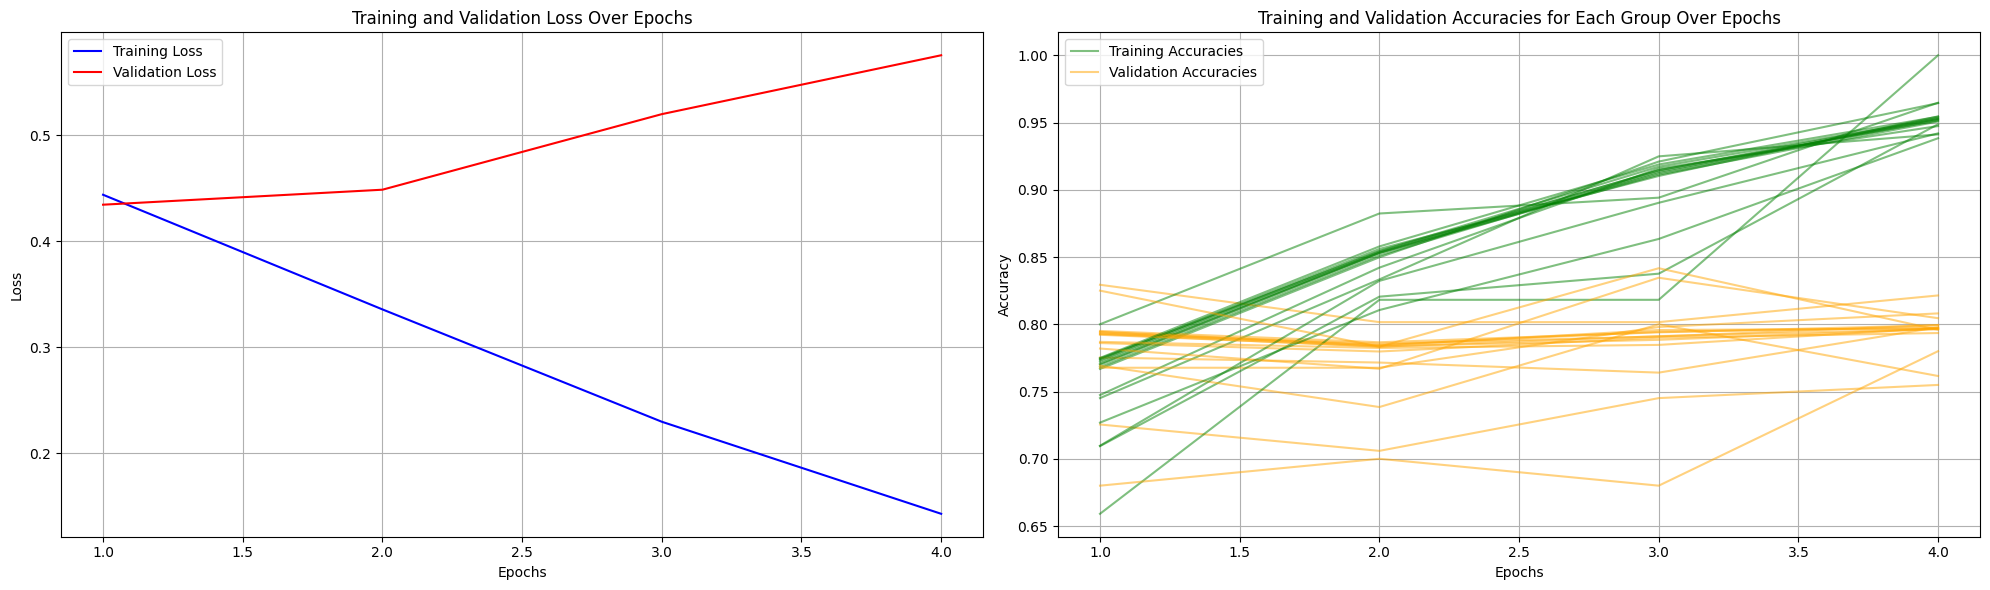

In [ ]:
# Usage example
EPOCHS = 4
train_losses, train_least_accuracies, train_least_accurate_groups, accuracies_per_group_during_training, val_losses, val_least_accuracies, val_least_accurate_groups, accuracies_per_group_during_validation = execute_training(EPOCHS, training_loader, validation_loader)


In [ ]:
test_x.index

RangeIndex(start=0, stop=133782, step=1)

In [ ]:
# Assuming your DataLoader is correctly set up to return batches of (input_ids, attention_mask)
test_dataloader = DataLoader(test_x, batch_size=512, shuffle=False)

model.eval()  # Make sure the model is in evaluation mode

test_predictions = []
indices = []

for batch in test_dataloader:
    input_ids, attention_mask = batch['input_ids'].to(device), batch['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.sigmoid(outputs).squeeze()  # Use sigmoid if your labels are between 0 and 1
        test_predictions.extend(predictions.cpu().numpy())
        indices.extend(input_ids.tolist())
        # No need to handle indices here unless your dataset provides them

# Convert test_predictions to the desired format for submission


KeyError: 0

In [ ]:
class BaselineDataset(Dataset):
    def __init__(self, data_dir, mode, vectorizer=None):
        super(BaselineDataset, self).__init__()
        assert mode in ['train', 'val', 'test']
        self.mode = mode

        # load the data
        self.data = pd.read_csv(os.path.join(data_dir, f'{mode}_x.csv'), index_col=0)

        # load the labels if not the test set
        if self.mode != 'test':
            self.label = pd.read_csv(os.path.join(data_dir, f'{mode}_y.csv'))

        # train the vectorizer if train set
        if self.mode == 'train':
            self.vectorizer = CountVectorizer()
            self.vectorizer.fit(self.data.values.flatten().tolist())
            self.vocab_size = len(self.vectorizer.vocabulary_)
        # otherwise use the vectorizer given as arguments (which was trained on the train set)
        else:
            self.vectorizer = vectorizer
            self.vocab_size = len(self.vectorizer.vocabulary_)

    def __len__(self):
        return len(self.data)
    def head(self, n=2000):
        return self.data.head(n)

    def __getitem__(self, idx):
        x = self.data.iloc[idx, 0]
        x = self.vectorizer.transform([x]).toarray()
        x = torch.tensor(x).float()
        length= x.shape[1]
        if self.mode == 'test':
            return x, idx
        else:
            y = torch.tensor([self.label.iloc[idx, -2]])
            return x, y, idx

Once we are happy with our results, we want to make a prediction on the test set. Your submission `.csv` file should contain 2 columns:
- ID: with the id of each prediction (do not shuffle to not mix things up)
- pred: the prediction of the model (thresholded or not)

In [ ]:
#model = RandomClassifier()
#test_dataset = BaselineDataset(data_dir, 'test', train_dataset.vectorizer)
data_dir = 'drive/MyDrive/Kaggle'

test_dataset = BaselineDataset(data_dir, 'test', train_dataset.vectorizer)

test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)
model.eval()
test_predictions, indices = [], []
for x, idx in tqdm(test_dataloader, leave=False):
  x=x.to(device)
  idx=idx.to(device)
  with torch.no_grad():
    pred = (model(x.long(),idx).squeeze() > 0.5).int()
  test_predictions.extend(pred.tolist())
  indices.extend(idx.tolist())

OutOfMemoryError: CUDA out of memory. Tried to allocate 185.10 GiB. GPU 0 has a total capacty of 14.75 GiB of which 10.73 GiB is free. Process 12092 has 4.02 GiB memory in use. Of the allocated memory 3.23 GiB is allocated by PyTorch, and 672.87 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
test_dataloader

In [ ]:
pred_df = pd.DataFrame({'ID': indices, 'pred': test_predictions})
pred_df.to_csv('prediction3.csv', index=False)